#### iris.csv 에서 데이터를 가져와 Dataset 만들기

In [3]:
# 1. Load Data
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
print(X[:10], y[:10], sep='\n')

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
[0 0 0 0 0 0 0 0 0 0]


In [4]:
# 2. Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=11, stratify=y_train)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(96, 4) (24, 4) (30, 4) (96,) (24,) (30,)


In [30]:
# 3. Dataset class
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class IrisDataset(Dataset):
    def __init__(self, X, y):
        super(IrisDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.classes = np.unique(self.y).tolist()
        self.len = len(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
train_dataset = IrisDataset(X_train, y_train)
val_dataset = IrisDataset(X_val, y_val)
test_dataset = IrisDataset(X_test, y_test)

print(train_dataset[0], val_dataset[0], test_dataset[0], sep='\n')
train_dataset.classes

(tensor([5.7000, 4.4000, 1.5000, 0.4000]), tensor(0))
(tensor([4.9000, 2.5000, 4.5000, 1.7000]), tensor(2))
(tensor([6.5000, 2.8000, 4.6000, 1.5000]), tensor(1))


[0, 1, 2]

In [34]:
# 4. DataLoader
Batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)  # shuffle할 필요 없대
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))

24 6 8


In [56]:
# Check Data
def print_batch_data(loader, epoch, batch_size=1, shuffle=False, drop_last=False, sampler=None):
    print(f'설정 값 : batch_size={batch_size}, shuffle={shuffle}, drop_last={drop_last}, sampler={sampler}')
    
    for ep in range(epoch):
        print(f'Epoch {ep+1} : {len(loader)}개')
        for i, (X_batch, y_batch) in enumerate(loader):
            print(f'Batch {i+1} - X_batch : {X_batch.shape}, y_batch : {y_batch.shape}, x : {X_batch}, y : {y_batch}')
            if i == 1:
                break

In [57]:
print_batch_data(train_loader, 1, batch_size=4, shuffle=True, drop_last=False, sampler=None)
print_batch_data(train_loader, 1, batch_size=4, shuffle=False, drop_last=False, sampler=None)

설정 값 : batch_size=4, shuffle=True, drop_last=False, sampler=None
Epoch 1 : 24개
Batch 1 - X_batch : torch.Size([4, 4]), y_batch : torch.Size([4]), x : tensor([[5.0000, 3.3000, 1.4000, 0.2000],
        [6.7000, 3.3000, 5.7000, 2.1000],
        [5.2000, 4.1000, 1.5000, 0.1000],
        [6.4000, 2.8000, 5.6000, 2.2000]]), y : tensor([0, 2, 0, 2])
Batch 2 - X_batch : torch.Size([4, 4]), y_batch : torch.Size([4]), x : tensor([[6.3000, 3.3000, 6.0000, 2.5000],
        [6.7000, 3.1000, 5.6000, 2.4000],
        [4.7000, 3.2000, 1.6000, 0.2000],
        [5.0000, 3.5000, 1.6000, 0.6000]]), y : tensor([2, 2, 0, 0])
설정 값 : batch_size=4, shuffle=False, drop_last=False, sampler=None
Epoch 1 : 24개
Batch 1 - X_batch : torch.Size([4, 4]), y_batch : torch.Size([4]), x : tensor([[4.7000, 3.2000, 1.3000, 0.2000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [5.9000, 3.2000, 4.8000, 1.8000],
        [4.4000, 2.9000, 1.4000, 0.2000]]), y : tensor([0, 2, 1, 0])
Batch 2 - X_batch : torch.Size([4, 4]), y_b

In [35]:
train_loader.dataset[0]

(tensor([5.7000, 4.4000, 1.5000, 0.4000]), tensor(0))

In [45]:
# 5. Model
import torch.nn as nn
import torch.nn.functional as F

class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [46]:
# 6. Train & Test
import torch.optim as optim
from torch.optim import lr_scheduler

Epochs = 30
model = IrisModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# stepLR vs ReduceLROnPlateau
#   - stepLR: step_size마다 gamma배 만큼 lr을 줄임
#   - ReduceLROnPlateau: val_loss가 줄어들지 않을 때 lr을 줄임
#   - 이 예제에서 stepLR을 사용한 이유 : 여기서 val_loss가 주는 건 의미가 없대

for epoch in range(Epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader.dataset):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss {running_loss/len(train_loader.dataset)}')
    scheduler.step()
    if scheduler.get_last_lr()[0] < 0.0001:
        print('Early Stopping : Learning Rate < 0.0001')
        break

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader.dataset:
            inputs, labels = data
            outputs = model(inputs)
            # print(outputs)
            predicted = torch.argmax(outputs)
            total += labels
            correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch+1}, Val Accuracy {correct/total}')

Epoch 1, Loss 0.9330677647764484
Epoch 1, Val Accuracy 0.6666666865348816
Epoch 2, Loss 0.6015017291841408
Epoch 2, Val Accuracy 0.6666666865348816
Epoch 3, Loss 0.4566278137887518
Epoch 3, Val Accuracy 0.7916666865348816
Epoch 4, Loss 0.387158243819916
Epoch 4, Val Accuracy 0.9583333730697632
Epoch 5, Loss 0.3351638998525838
Epoch 5, Val Accuracy 1.0
Epoch 6, Loss 0.2918877634219825
Epoch 6, Val Accuracy 1.0
Epoch 7, Loss 0.2533090479288755
Epoch 7, Val Accuracy 1.0
Epoch 8, Loss 0.22127276432244494
Epoch 8, Val Accuracy 1.0
Epoch 9, Loss 0.19561310027105114
Epoch 9, Val Accuracy 1.0
Epoch 10, Loss 0.17553900572723555
Epoch 10, Val Accuracy 1.0
Epoch 11, Loss 0.14777544578282686
Epoch 11, Val Accuracy 1.0
Epoch 12, Loss 0.1436383337143828
Epoch 12, Val Accuracy 1.0
Epoch 13, Loss 0.14217925674468765
Epoch 13, Val Accuracy 1.0
Epoch 14, Loss 0.14088552772712623
Epoch 14, Val Accuracy 1.0
Epoch 15, Loss 0.13965322589016674
Epoch 15, Val Accuracy 1.0
Epoch 16, Loss 0.13842716214336784
Ep

In [22]:
# 7. Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader.dataset:
        inputs, labels = data
        outputs = model(inputs)
        predicted = torch.argmax(outputs)
        total += labels
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy {correct/total}')

Test Accuracy 1.0


In [44]:
# 8. New Data
import numpy as np
new_data = np.array([[5.1, 3.5, 1, 0.2], [6.2, 2, 5.4, 2.3], [7.2, 3.6, 3, 2.5]])
new_data = torch.tensor(new_data, dtype=torch.float32)
model.eval()
with torch.no_grad():
    for data in new_data:
        outputs = model(data)
        predicted = torch.argmax(outputs)
        # {0: 'setosa', 1: 'versicolor', 2: 'virginica'} 으로 변환
        if predicted == 0:
            print('setosa')
        elif predicted == 1:
            print('versicolor')
        else:
            print('virginica')

setosa
virginica
versicolor


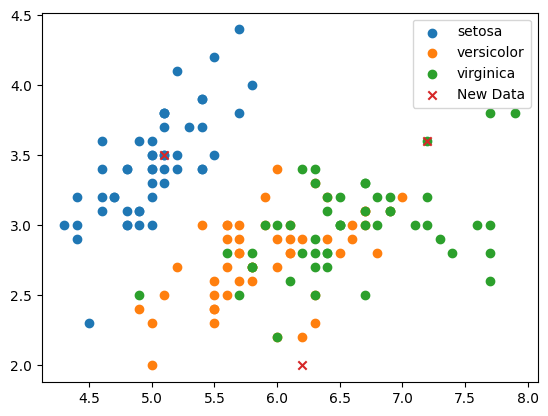

In [41]:
# Visualize
import matplotlib.pyplot as plt

# 1) data 분배 그래프 + new_data 그래프
fig, ax = plt.subplots()
for i in range(3):
    ax.scatter(X[y == i][:, 0], X[y == i][:, 1], label=iris.target_names[i])
ax.scatter(new_data[:, 0], new_data[:, 1], label='New Data', marker='x')
ax.legend()
plt.show()
